In [2]:
from datetime import datetime
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

BASE_DATA_PATH = os.path.join("out")
OUTPUT_FOLDER = os.path.join("out", "plots")

def get_dataset_file(cloud_name, timestamp = "latest", data_path = BASE_DATA_PATH):
    # Get all CSV files in the folder
    csv_folder = os.path.join(data_path, cloud_name)
    csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))
    df = None
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in the folder: {csv_folder}")
    
    if timestamp == 'latest':
        # Parse filenames and find the latest based on the timestamp in the name
        file = max(csv_files, key=lambda x: datetime.strptime(
            '-'.join(x.split('-')[1:]).replace('.csv', ''),
            "%Y-%m-%d-%H:%M:%S"
        ))
        print(f"Loading latest file: {file}")
        df = pd.read_csv(file)
    else:
        # Check for exact match with the date_str in the filename (ignoring the prefix)
        for file in csv_files:
            filename = os.path.basename(file)
            file_timestamp = filename.split('-')[1:]  # Split to get timestamp part
            file_timestamp = '-'.join(file_timestamp).replace('.csv', '')  # Rebuild timestamp string
            if timestamp == file_timestamp:
                print(f"Loading file: {file}")
                df = pd.read_csv(file)
        if df is None:
               FileNotFoundError(f"File with date '{timestamp}' not found in folder: {csv_folder}")
    # Convert times to milliseconds
    df['mean'] = df['mean'] * 1000
    df['stdev'] = df['stdev'] * 1000# 
    df['warmup_time'] = df['warmup_time'] * 1000
    return df

def read_multiple_datasets(clouds_datasets, data_path = BASE_DATA_PATH):
    dfs = {}
    for cloud, dataset in clouds_datasets.items():
        dfs[cloud] = get_dataset_file(cloud, "latest", data_path)
    return dfs

def output_fig(fig, filename, dataset = "all", cloud = None):
    output_folder = ""
    if cloud is None:
        output_folder = os.path.join(OUTPUT_FOLDER, dataset)
    else:
        output_folder = os.path.join(OUTPUT_FOLDER, dataset, cloud)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    fig.savefig(os.path.join(output_folder, filename), dpi=300, bbox_inches='tight')
    plt.close(fig)

In [3]:
plt.rcParams.update({
    'font.family': 'sans-serif',  # Use sans-serif as a fallback
    'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'],
    
    'font.size': 10,
    'axes.labelsize': 9,
    'axes.titlesize': 11,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'figure.titlesize': 12,
    
    'axes.grid': True,
    'axes.grid.axis': 'y',  # Only horizontal grid lines
    'grid.linestyle': '-',  # Solid line
    'grid.linewidth': 0.4,  # Very thin grid lines
    'grid.color': '#CCCCCC',  # Light gray grid
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),  # Standard publication-friendly figure size
    'figure.dpi': 100, # Smaller preview
    # 'figure.dpi': 300, 
    
    'lines.linewidth': 1.0,  # Consistent line thickness
    'lines.markersize': 4,  # Consistent marker size

    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white'   # Edge color of the figure
})

In [4]:
# Some aux. functions for plot information
def add_execution_details(cloud, dataset, searches, repeats, points, fig, h_ex=0.93):
    execution_details = [
        f"- {searches:,} searches x {repeats:,} repeats",
        f"- Point cloud: {cloud} ({points:,} points)",
        f"- Dataset: {dataset}",
    ]
    fig.text(0.10, h_ex,
            '\n'.join(execution_details),
            fontfamily='monospace',
            color='#505050',
            ha='left',
            va='top',
            linespacing=1.3)
    
def add_execution_details_multiple_datasets(clouds, searches, repeats, fig, h_ex=0.90):
    execution_details = [
        f"- {searches:,} searches x {repeats:,} repeats",
        f"- {len(clouds)} point clouds",
    ]
    fig.text(0.10, h_ex,
            '\n'.join(execution_details),
            fontfamily='monospace',
            color='#505050',
            ha='left',
            va='top',
            linespacing=1.3)

def add_title_subtitle(title, subtitle, fig, h_title=0.98, h_subtitle=0.95):
    fig.text(0.10, h_title, 
            title, 
            fontsize=16, 
            fontweight='bold', 
            ha='left', 
            va='top')

    fig.text(0.10, h_subtitle,
            subtitle,
            fontsize=12,
            fontstyle='italic',
            color='#404040',
            ha='left',
            va='top')

def add_octree_types_legend(legend_handles, legend_labels, legend_title, fig):
    fig.legend(
        legend_handles,
        legend_labels,
        title=legend_title,
        loc="upper right",
        bbox_to_anchor=(0.9, 1)
    )

In [5]:
# This dicts store information about the type parameters and possible combinations used in each visualization, 
# along with the palette of colors
TYPES_INFO_OCTREE_ENCODER = {
    "type_parameters":  ['octree', 'encoder'],
    "available_types": pd.DataFrame({
        'octree': ['Linear', 'Linear', 'Pointer', 'Pointer', 'Pointer'],
        'encoder': ['HilbertEncoder3D', 'MortonEncoder3D', 'HilbertEncoder3D', 'MortonEncoder3D', 'Unencoded']
    }),

    "palette": {
        ('Linear', 'HilbertEncoder3D'): '#1984c5',
        ('Linear', 'MortonEncoder3D'): '#63bff0',
        ('Pointer', 'HilbertEncoder3D'): '#c23728',
        ('Pointer', 'MortonEncoder3D'): '#de6e56',
        ('Pointer', 'Unencoded'): '#e1a692'
    }
}

TYPES_INFO_OCTREE_POINT = {
    "type_parameters":  ['octree', 'point_type'],
    "available_types": pd.DataFrame({
        'octree': ['Linear', 'Linear', 'Linear', 'Pointer', 'Pointer', 'Pointer'],
        'point_type': ['Point', 'Lpoint64', 'Lpoint', 'Point', 'Lpoint64', 'Lpoint']
    }),
    "palette": {
        ('Linear', 'Point'): '#0f5f87',
        ('Linear', 'Lpoint64'): '#1984c5',
        ('Linear', 'Lpoint'): '#63bff0',
        ('Pointer', 'Point'): '#9f1b17',
        ('Pointer', 'Lpoint64'): '#de6e56',
        ('Pointer', 'Lpoint'): '#e1a692'
    }
}

In [6]:
def octree_runtime_comparison(cloud, dataset, operation, operation_name, show_warmup_time=False, types_info=TYPES_INFO_OCTREE_ENCODER, data_path=BASE_DATA_PATH):
    df = get_dataset_file(cloud, "latest", data_path)
    # Filter the dataset for the specified operation
    operation_df = df[df['operation'] == operation]
   
    # Get unique radii and kernels
    radii = sorted(operation_df['radius'].unique())
    kernels = operation_df['kernel'].unique()
   
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)),
                              gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
   
    # Bar spacing parameters
    bar_width = 0.15
    group_width = bar_width * len(types_info["available_types"])
    group_gap = 0.5
   
    legend_handles, legend_labels = [], []
    # First loop through each radius: 1.0, 2.5, 5.0, ...
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = operation_df[operation_df['radius'] == radius]
       
        # Now iterate through kernels: circle, sphere, square, cube, ...
        kernel_labels = []
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'{kernel} kernel\nNo data available')
                continue
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f'{kernel} kernel\nAvg. points found: {avg_total:,.0f}')
           
            # Finally, iterate through each of the octree implementations identified by the (octree, encoder, point_type) tuple
            for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
                # Extract parameters dynamically from the row
                key = tuple(params[col] for col in types_info["type_parameters"])
                octree_data = kernel_data[
                    (kernel_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]
                if octree_data.empty:
                    continue
                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                warmup_times = octree_data['warmup_time'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                
                # Main execution time bar
                bar = ax.bar(x_pos, means[0], bar_width,
                             color=types_info["palette"][key])
                
                # Warmup time bar (if enabled)
                if show_warmup_time:
                    ax.bar(x_pos, warmup_times[0], bar_width, 
                           color="none", 
                           edgecolor='black', alpha = 0.5,
                           zorder=-2)  # Ensure it's drawn on top
                
                ax.errorbar(x_pos, means[0], stdevs[0],
                            color='gray', capsize=3, capthick=1,
                            fmt='none', elinewidth=1)
               
                formatted_label = ", ".join(f"{value}" for param, value in zip(types_info["type_parameters"], key))
                if radius_idx == 0 and formatted_label not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)
        
        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
       
        ax.text(0.04, 0.96, f'Radius = {radius}',
                transform=ax.transAxes,
                fontsize=12, fontweight='bold',
                va='top', ha='left')
       
        ax.set_ylabel('Execution time (ms)')
   
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)
    add_title_subtitle(f"{operation_name} performance analysis", 
                       f"Analysis of octree type over multiple search radii and kernels{' with warmup times' if show_warmup_time else ''}", 
                       fig)
    # The number of searches, repeats and points in the dataframe are in every row of the csv
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
    add_execution_details(cloud, dataset, nsearches, nrepeats, npoints, fig)
    return fig

Loading latest file: out/Lille_0/Lille_0-2025-02-28-17:10:08.csv


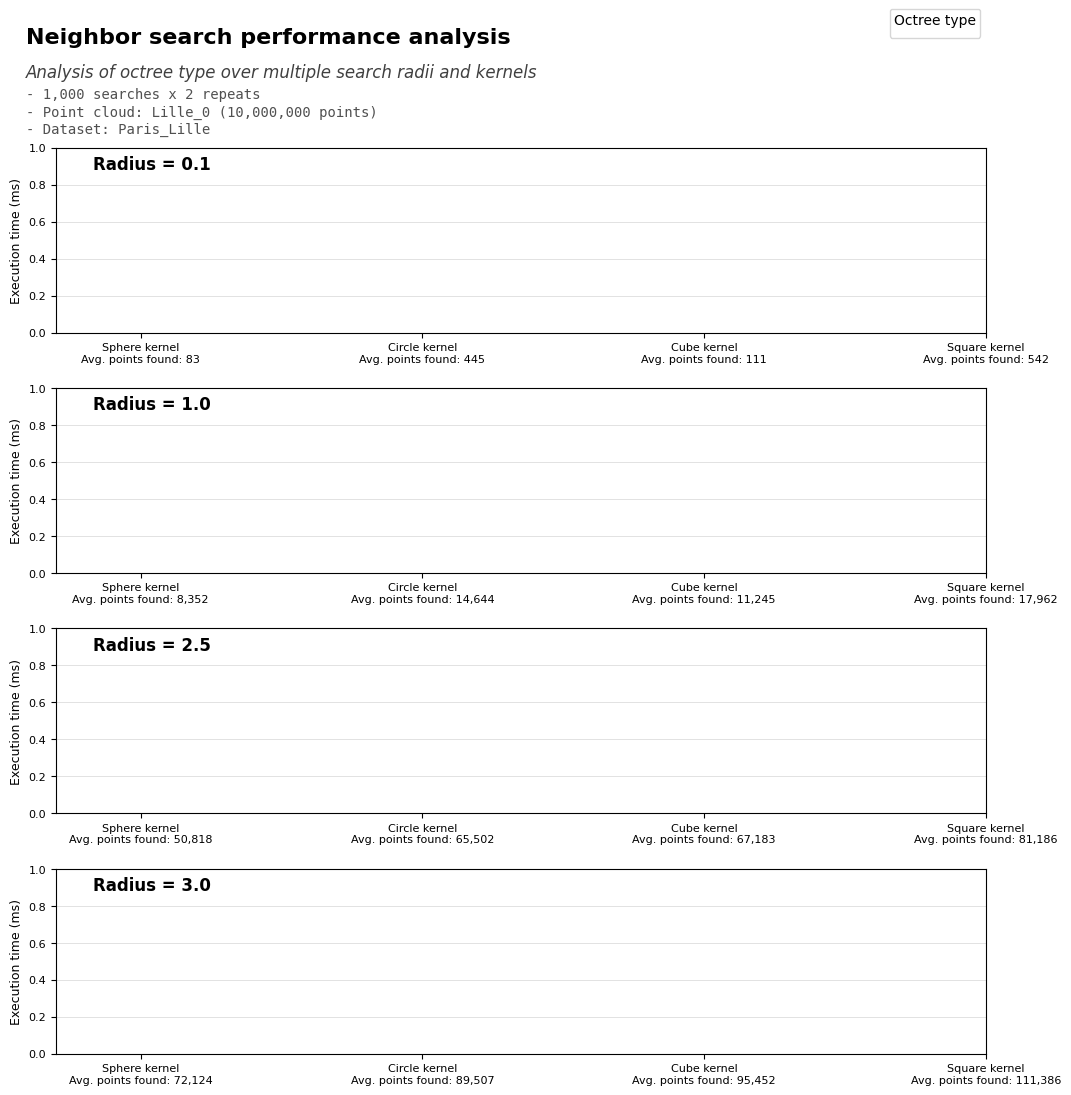

In [7]:
# Plot comparison of neighSearch runtimes for Lille_0 across all radii kernels benchmarked and all octree types
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", 'neighSearch', 'Neighbor search')

Loading latest file: out/Lille_0/Lille_0-2025-02-28-17:10:08.csv


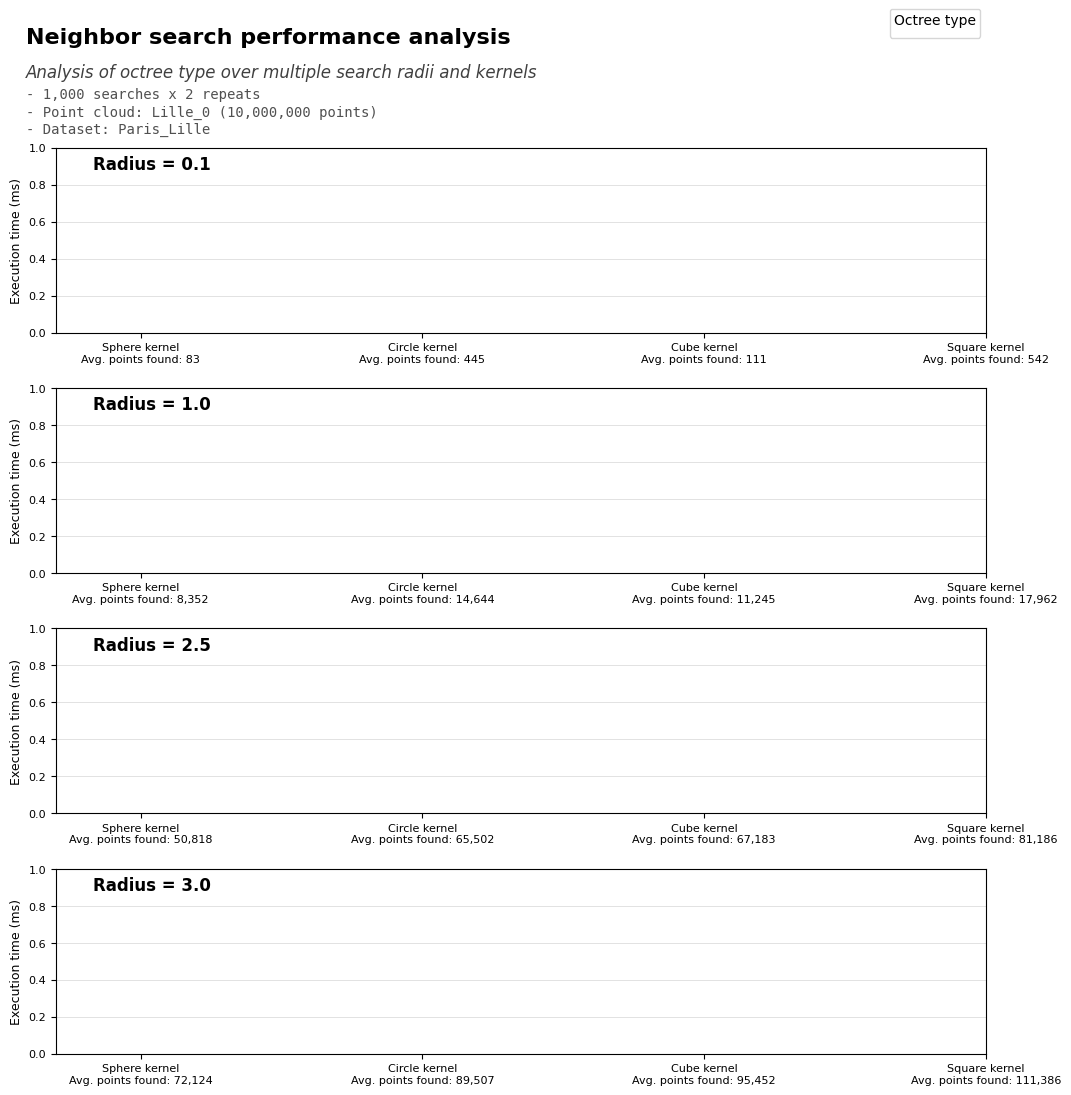

In [8]:
# Plot comparison of neighSearch runtimes for Lille_0 across all radii kernels benchmarked and all octree types
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", 'numNeighSearch', 'Neighbor search')

Loading latest file: out/Lille_0/Lille_0-2025-02-28-17:10:08.csv


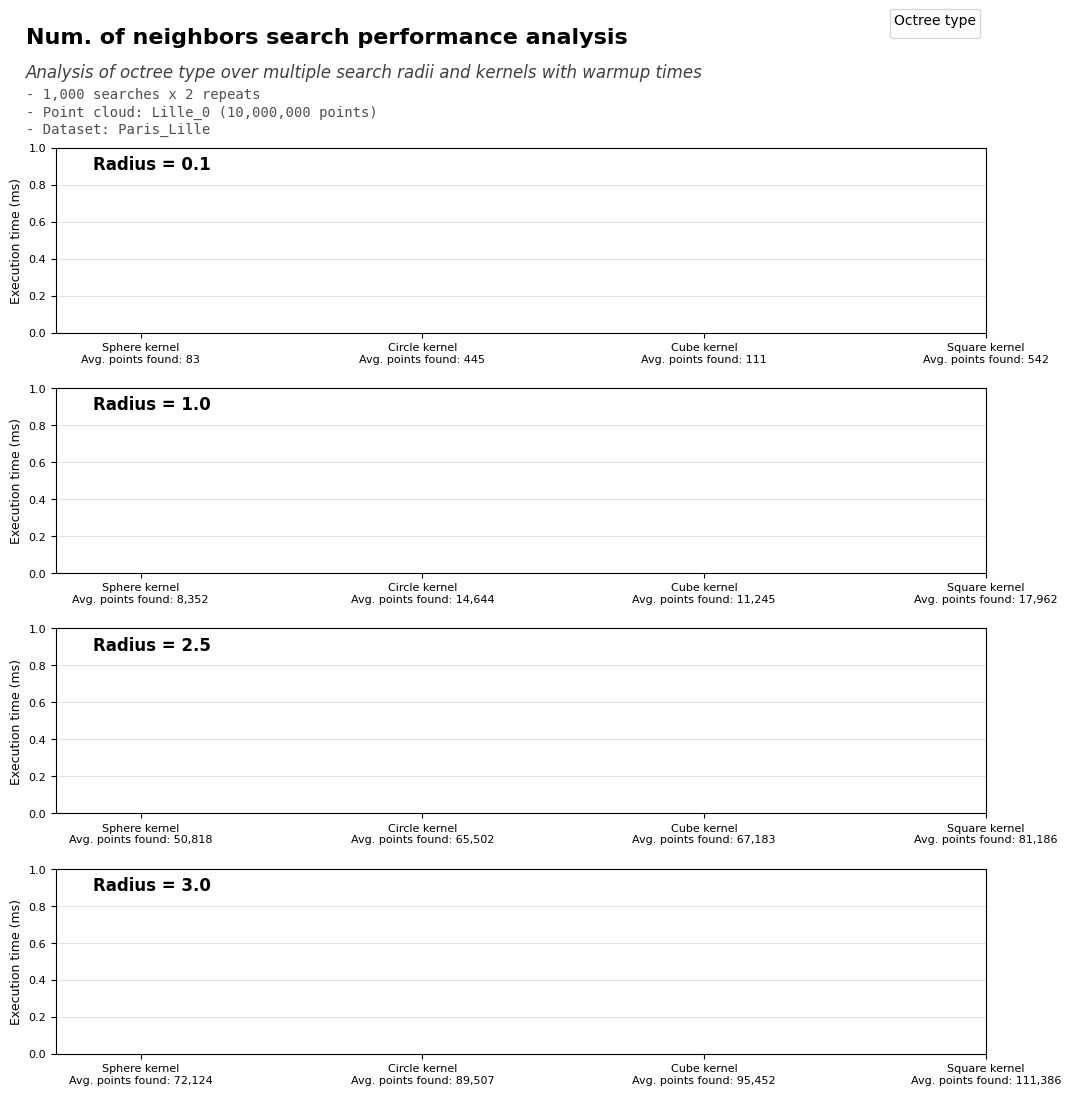

In [9]:
# Same plots but with warmup times
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", 'neighSearch', 'Num. of neighbors search', True)

Loading latest file: out/Lille_0/Lille_0-2025-02-28-17:10:08.csv


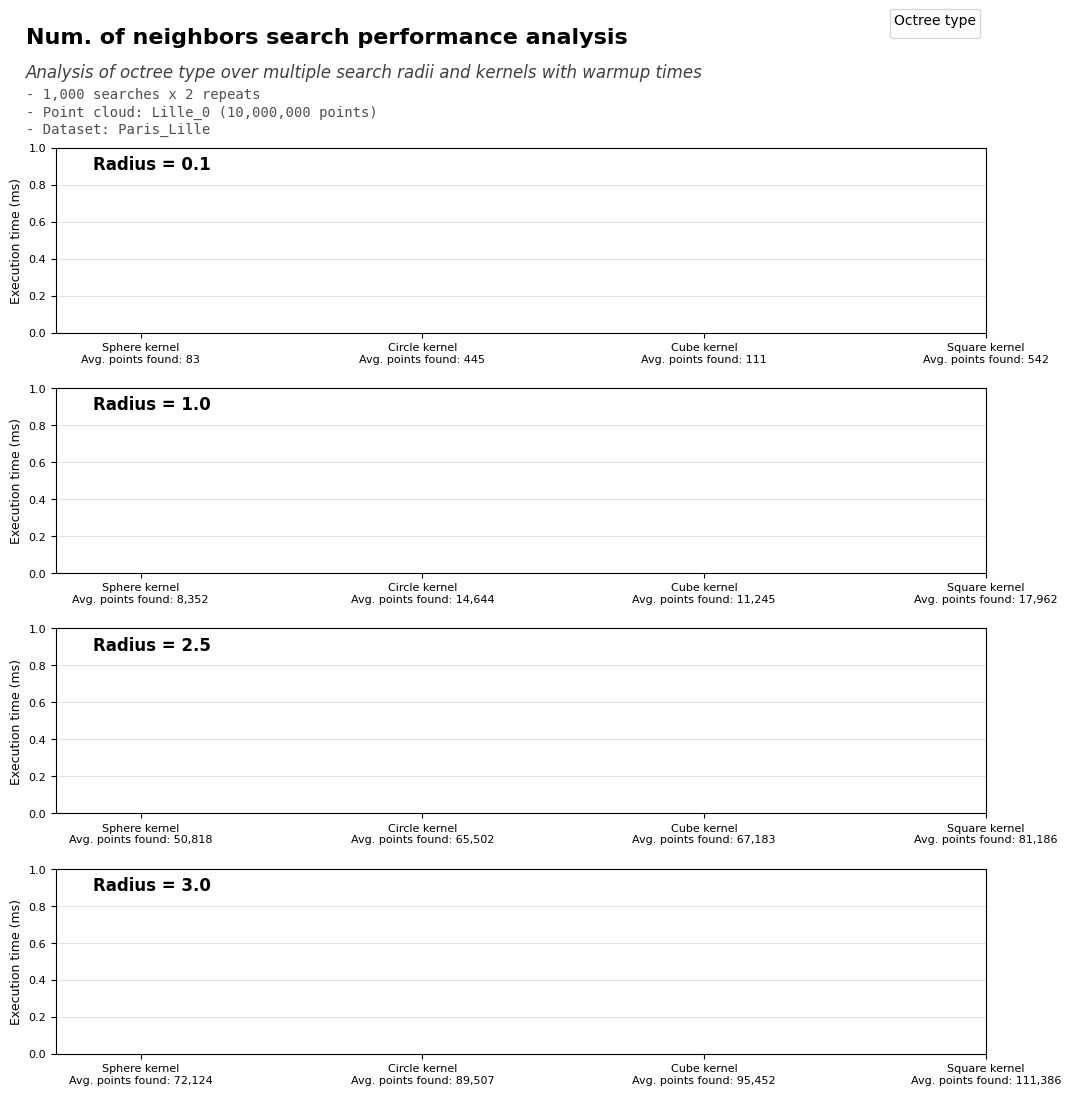

In [10]:
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", 'numNeighSearch', 'Num. of neighbors search', True)

Loading latest file: out/point_comp/Lille_0/Lille_0-2025-01-28-13:06:05.csv


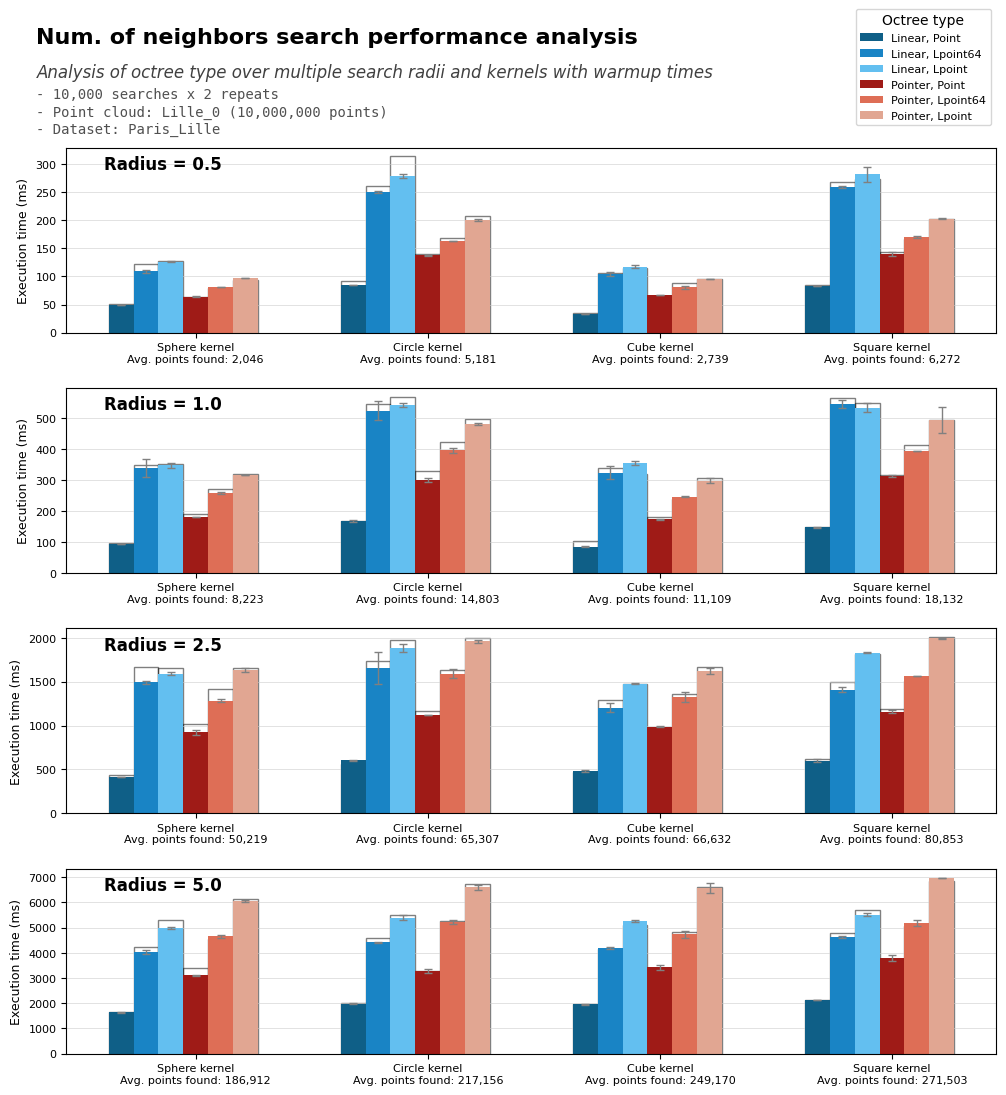

In [11]:
fig = octree_runtime_comparison("Lille_0", "Paris_Lille", 'neighSearch', 'Num. of neighbors search', True, TYPES_INFO_OCTREE_POINT, os.path.join(BASE_DATA_PATH, "point_comp"))

In [12]:
ALGO_COMP_DATA_PATH = OUTPUT_FOLDER = os.path.join("out", "struct_vs_vect")

In [13]:
def octree_operations_comparison(cloud, dataset, operations, palette, data_path=ALGO_COMP_DATA_PATH):
    df = get_dataset_file(cloud, "latest", data_path)
    # Filter for the specified operations
    df = df[df['operation'].isin(operations)]
    
    # Get unique radii and kernels
    radii = sorted(df['radius'].unique())
    kernels = df['kernel'].unique()
    
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)),
                           gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
    
    # Bar spacing parameters
    bar_width = 0.35 / len(operations)  # Dynamically adjust width based on operation count
    group_width = bar_width * len(operations)
    group_gap = 0.10
    
    legend_handles, legend_labels = [], []
    
    # First loop through each radius
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        radius_data = df[df['radius'] == radius]
        
        # Now iterate through kernels
        kernel_labels = []
        for i, kernel in enumerate(kernels):
            kernel_data = radius_data[radius_data['kernel'] == kernel]
            if kernel_data.empty:
                kernel_labels.append(f'{kernel} kernel\nNo data available')
                continue
            
            avg_total = kernel_data['avg_result_size'].iloc[0]
            kernel_labels.append(f'{kernel} kernel\nAvg. points found: {avg_total:,.0f}')
            
            for j, operation in enumerate(operations):
                op_data = kernel_data[kernel_data["operation"] == operation]
                if op_data.empty:
                    print(f"Warning: No data found for operation {operation} in radius {radius} and kernel {kernel}")
                    continue
                
                means = op_data['mean'].values
                stdevs = op_data['stdev'].values
                x_pos = i * (group_width + group_gap) + j * bar_width
                
                # Get color from palette, with fallback for extra operations
                color_idx = j % len(palette)
                bar = ax.bar(x_pos, means[0], bar_width,
                            color=palette[color_idx])
                ax.errorbar(x_pos, means[0], stdevs[0],
                           color='gray', capsize=3, capthick=1,
                           fmt='none', elinewidth=1)
                
                if radius_idx == 0 and operation not in legend_labels:
                    legend_handles.append(bar)
                    legend_labels.append(operation)
        
        # Set kernel labels
        kernel_group_centers = [i * (group_width + group_gap) + group_width/2 - bar_width/2 for i in range(len(kernels))]
        ax.set_xticks(kernel_group_centers)
        ax.set_xticklabels(kernel_labels)
        
        ax.text(0.04, 0.96, f'Radius = {radius}',
               transform=ax.transAxes,
               fontsize=12, fontweight='bold',
               va='top', ha='left')
        
        ax.set_ylabel('Execution time (ms)')
    
    # Create a descriptive title for multiple operations
    title = " vs ".join(operations)
    subtitle = "Analysis of performance differences between multiple search algorithms"
    
    add_octree_types_legend(legend_handles, legend_labels, "Operation performed", fig)
    add_title_subtitle(title, subtitle, fig)
    
    # The number of searches, repeats and points in the dataframe are in every row of the csv
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    npoints = df['npoints'].iloc[0]
    add_execution_details(cloud, dataset, nsearches, nrepeats, npoints, fig)
    
    return fig

Loading latest file: out/struct_vs_vect/Lille_0/Lille_0-2025-02-28-19:27:48.csv


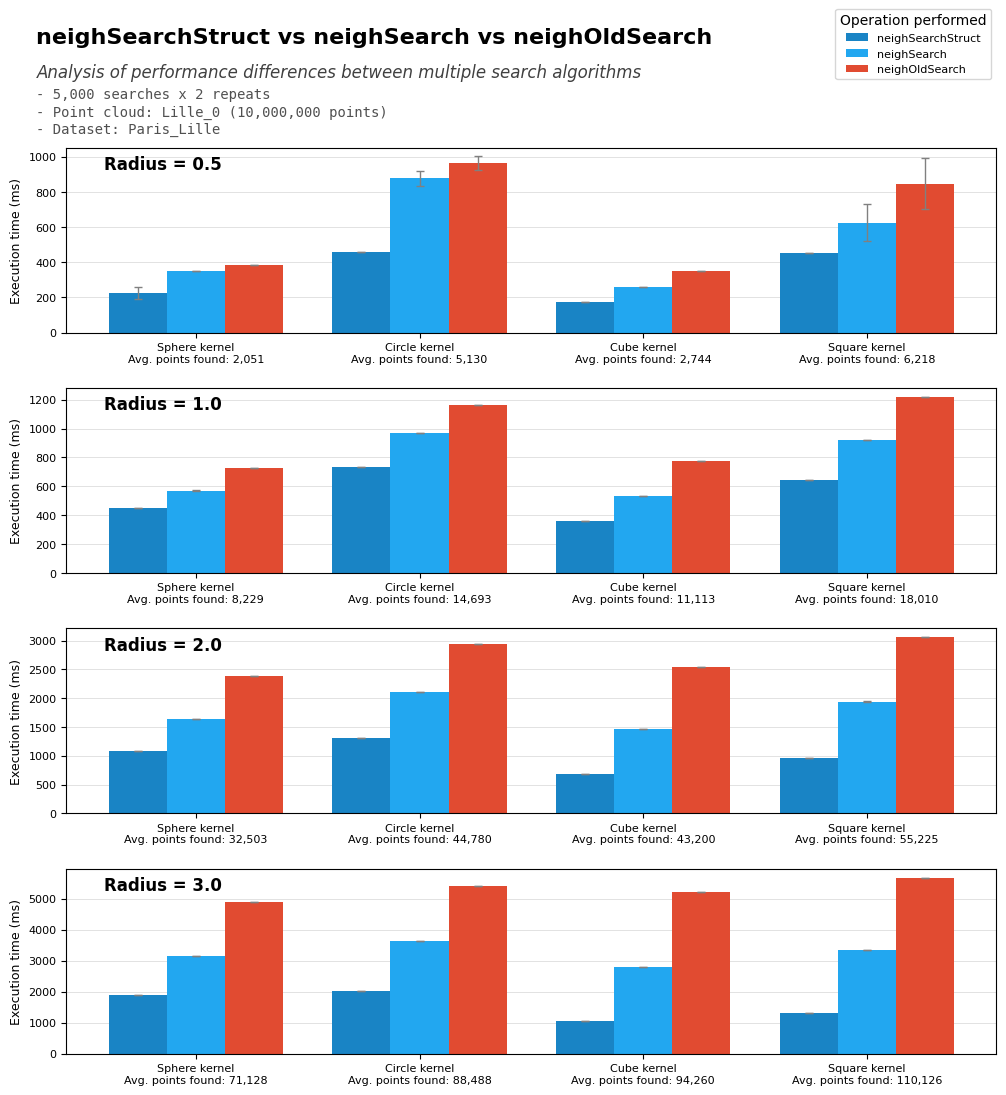

In [14]:
search_impl_palette = ["#1984c5", "#22a7f0", "#e14b31"]
fig = octree_operations_comparison("Lille_0", "Paris_Lille", ['neighSearchStruct', 'neighSearch', 'neighOldSearch'], search_impl_palette)

Loading latest file: out/struct_vs_vect/Lille_0/Lille_0-2025-02-28-19:27:48.csv


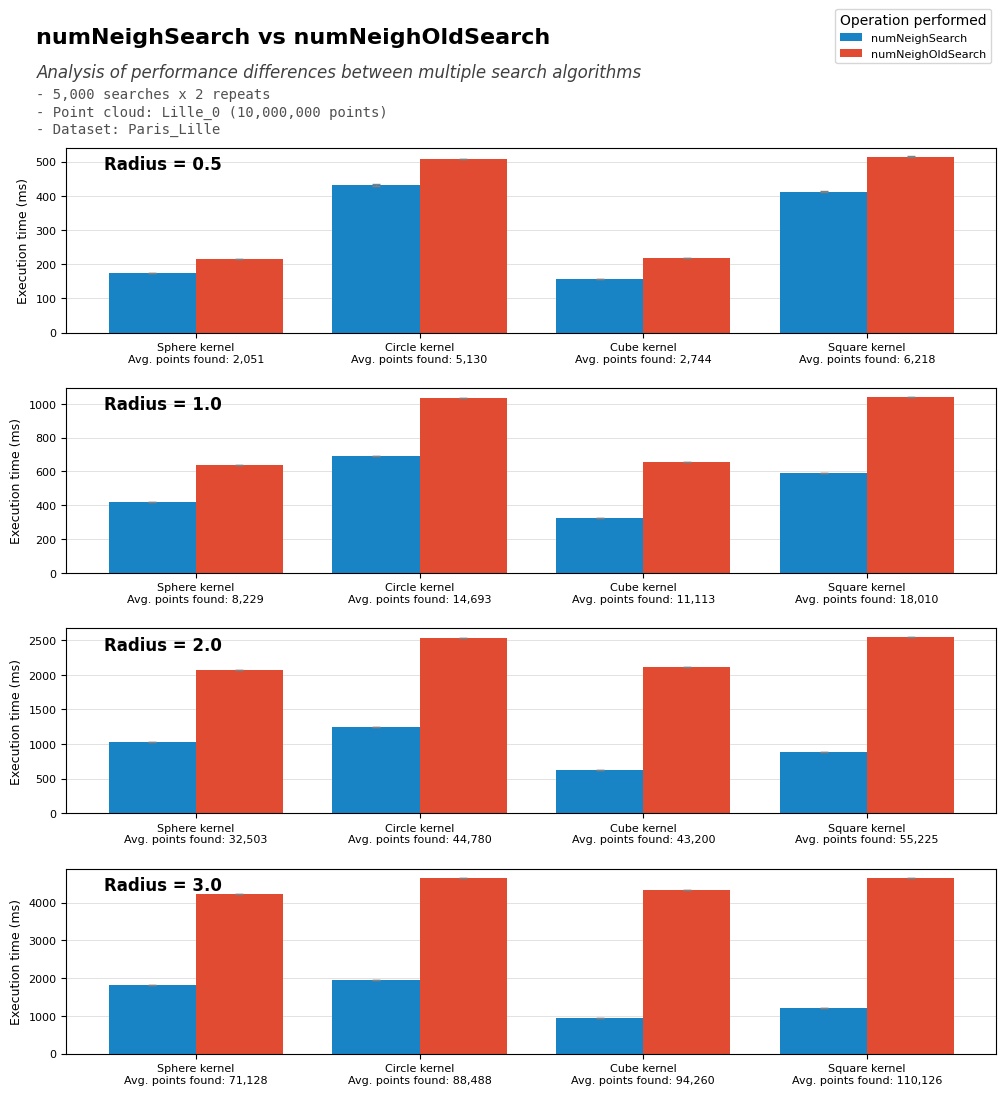

In [15]:
num_search_impl_palette = ["#1984c5", "#e14b31"]
fig = octree_operations_comparison("Lille_0", "Paris_Lille", ['numNeighSearch', 'numNeighOldSearch'], num_search_impl_palette)

Loading latest file: out/seq_vs_shuffle/Lille_0/Lille_0-2025-01-27-11:58:42.csv


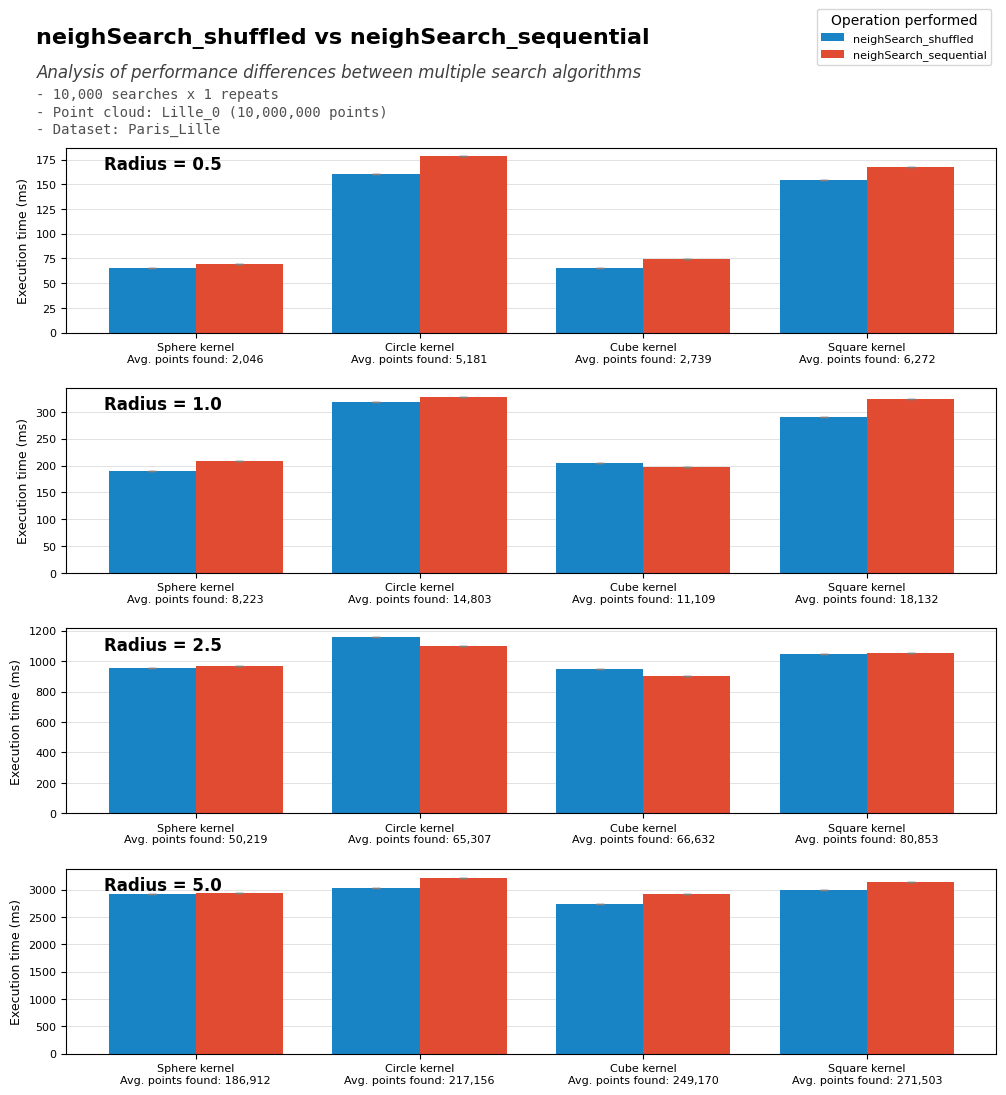

In [16]:
# Test shuffled vs sequential search sets
seq_vs_shuffled_path = os.path.join(BASE_DATA_PATH, "seq_vs_shuffle")
seq_vs_shuffled_palette = ["#1984c5", "#e14b31"]
fig = octree_operations_comparison("Lille_0", "Paris_Lille", ['neighSearch_shuffled', 'neighSearch_sequential'], seq_vs_shuffled_palette, seq_vs_shuffled_path)

In [17]:
def approximate_search_comparison(cloud, dataset, kernel="Sphere", data_path=ALGO_COMP_DATA_PATH):
    # Load data
    df = get_dataset_file(cloud, "latest", data_path)
    # Define operations and their colors
    operations = ['neighSearchStruct', 'neighSearchApproxUpper', 'neighSearchApproxLower']
    operations_palette = {
        'neighSearchStruct': "#3ca370",
        'neighSearchApproxUpper': '#1984c5',
        'neighSearchApproxLower': '#e14b31'
    }
    
    # Filter for the specified operations
    df = df[df['operation'].isin(operations)]
    # Filter by kernel too
    df = df[df['kernel'] == kernel]
    # Get unique radii
    radii = sorted(df['radius'].unique())
    
    # Create subplot grid with reduced vertical spacing
    fig, axes = plt.subplots(len(radii), 1, figsize=(12, 3 * len(radii)),
                           gridspec_kw={'hspace': 0.3})
    if len(radii) == 1:
        axes = [axes]
    
    legend_handles, legend_labels = [], []
    
    # Process each radius
    for radius_idx, radius in enumerate(radii):
        ax = axes[radius_idx]
        
        # Get data for this radius
        radius_data = df[df['radius'] == radius].copy()
        
        # Find baseline (exact search)
        baseline_row = radius_data[(radius_data['operation'] == 'neighSearchStruct') & 
                                 (radius_data['tolerance_percentage'] == 0)]
        if baseline_row.empty:
            ax.text(0.5, 0.5, f'No exact search data available for radius {radius}',
                  transform=ax.transAxes, ha='center', va='center')
            continue
        
        baseline = baseline_row['avg_result_size'].iloc[0]
        
        # Compute relative points
        radius_data['relative_points'] = (radius_data['avg_result_size'] / baseline) * 100
        
        # Remove approximate searches that equal the exact search
        # approx_mask = (radius_data['operation'] != 'neighSearchStruct') & (radius_data['relative_points'] == 100)
        # radius_data = radius_data[~approx_mask]
        
        # Connect points with gray line for each operation within this radius
        for op in operations:
            op_data = radius_data[radius_data['operation'] == op].sort_values('relative_points')
            if not op_data.empty:
                ax.plot(op_data['relative_points'], op_data['mean'],
                      color='gray', alpha=0.5, linestyle='-')
                
                # Plot the scatter points
                scatter = ax.scatter(op_data['relative_points'], op_data['mean'],
                                  color=operations_palette[op], s=80)
                
                # Add to legend only once
                if radius_idx == 0 and op not in legend_labels:
                    legend_handles.append(scatter)
                    legend_labels.append(op)
                
                # Annotate points with tolerance percentage
                for _, row in op_data.iterrows():
                    ax.annotate(f"{row['tolerance_percentage']}% tol", 
                              (row['relative_points'], row['mean']),
                              xytext=(5, 5), textcoords='offset points',
                              fontsize=8)
        
        ax.text(0.04, 0.96, f'Radius = {radius}',
               transform=ax.transAxes,
               fontsize=12, fontweight='bold',
               va='top', ha='left')
        
        y_max = radius_data['mean'].max()
        ax.set_ylim(0, y_max * 1.1)  # Increase by 10% the Y limit

        ax.set_xlabel("Points Found (% of exact search)")
        ax.set_ylabel("Execution time (ms)")
        ax.grid(True, alpha=0.3)
        ax.grid(True, alpha=0.3)
    
    # Add overall title and subtitle
    add_octree_types_legend(legend_handles, legend_labels, "Search method", fig)
    add_title_subtitle("Approximate Search Performance Analysis",
                      f"Execution time vs. percentage of points found, {kernel} kernel", fig)
    
    # Add execution details if available
    if not df.empty:
        nsearches = df['num_searches'].iloc[0]
        nrepeats = df['repeats'].iloc[0]
        npoints = df['npoints'].iloc[0]
        add_execution_details(cloud, dataset, nsearches, nrepeats, npoints, fig)
    
    return fig

Loading latest file: out/approx_search/Lille_0/Lille_0-2025-02-28-18:39:11.csv


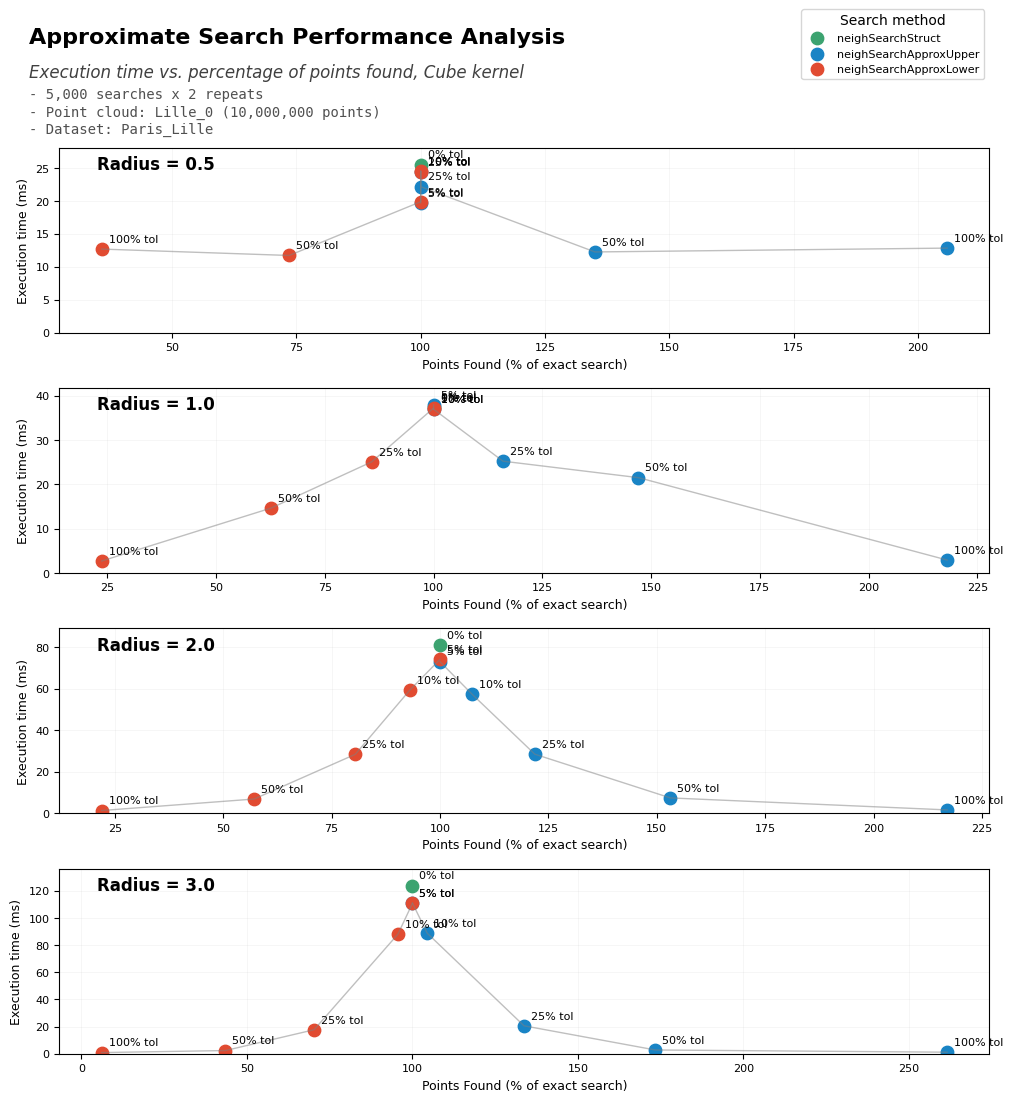

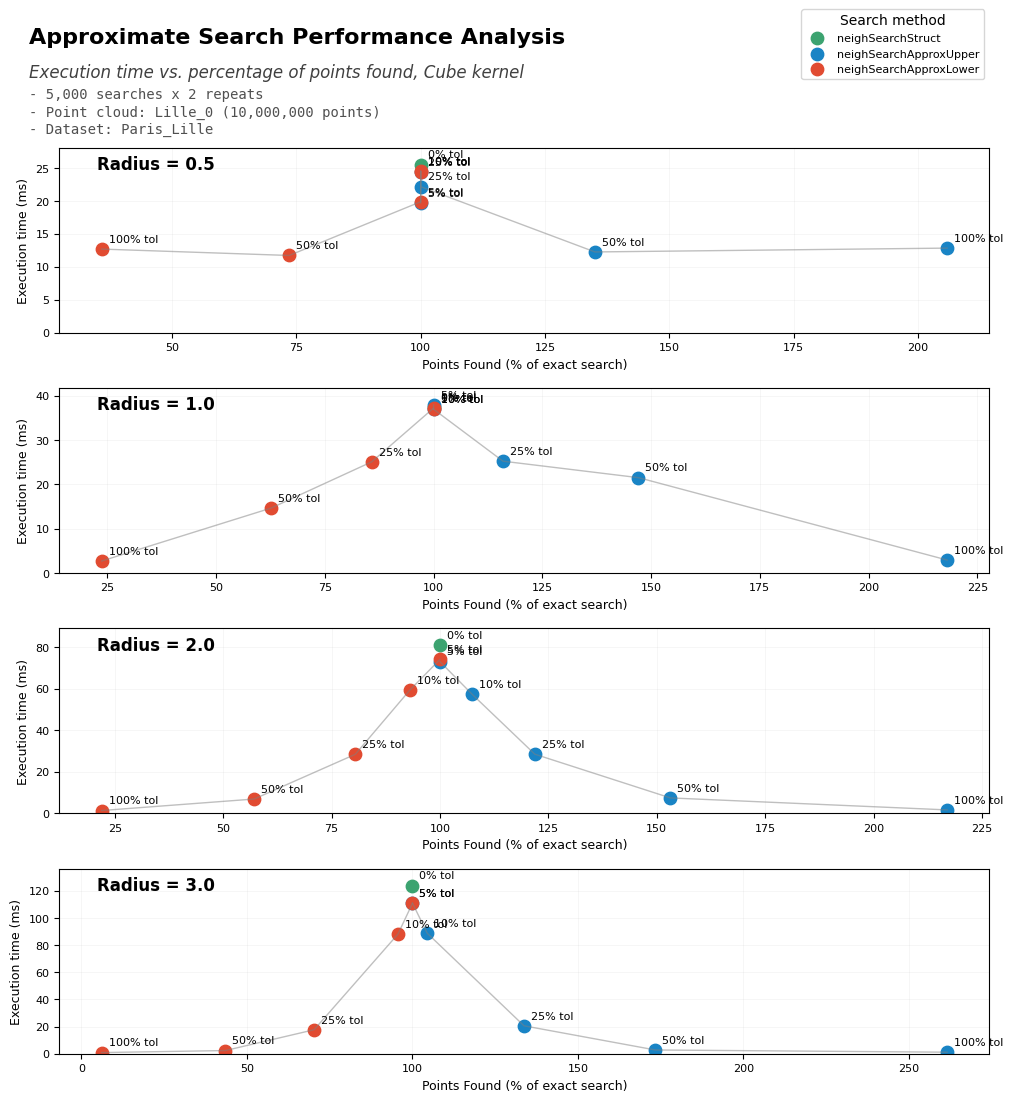

In [18]:
approx_data_path = os.path.join(BASE_DATA_PATH, "approx_search")
kernel_used = "Cube"
approximate_search_comparison("Lille_0", "Paris_Lille", kernel_used, approx_data_path)

In [19]:
TPP_DATA_PATH = os.path.join(BASE_DATA_PATH, "tpp_comp")
CLOUDS_DATASETS_TPP = {"alcoy": "alcoy",
                        "Lille_0": "Paris_Lille", 
                        "5110_54320": "Dales_LAS",
                        "5135_54435": "Dales_LAS",
                        "bildstein_station1_xyz_intensity_rgb": "Semantic3D",
                        "sg27_station8_intensity_rgb": "Semantic3D",
                        "station1_xyz_intensity_rgb": "Semantic3D",
                        "Speulderbos_2017_TLS": "Speulderbos"
                        }

In [20]:
# Ideas para plots de multiples datasets:
# 1. Fijar kernel, radio (al máximo por ejemplo) y una operación. Iterar para cada dataframe e implementación del octree.
# Plottear tamaño del dataset vs tiempo de ejecución / avg_result_size. En cada punto del line graph debería estar el nombre del dataset para que sea fácil interpretarlo. 
# Plottear una línea para cada implementación del octree.
# Los tamaños de los datasets están ordenados y están en forma de log plot en el eje x.
# Se debería ver como un dataset más grande hace que la eficiencia por punto encontrado sea peor, ya que habrá más fallos de caché y más overheads.
# El problema es poder escoger buen radio/kernel para que todos los datasets tengan un avg_result_size similar, ya que si es muy distinto no se podrá comparar bien,
# cuando el avg_result_size es muy pequeño, el tiempo por punto encontrado es más alto por los overheads. Así que hice varios métodos, uno de ellos es fijar el radio,
# otro escoger el radio de cada dataset que tiene el avg_result_size más grande y el último es escoger el radio que se acerca más a un valor target (avg_size_target).
# Los 2 últimos métodos eligen distintos radios para cada dataframe, y el último es el más interesante en mi opinión.

# 2. Fijar kernel y para cada radio (no todos estarán disponibles en todos los datasets por densidades diferentes), imprimir cada uno de los runtimes
# para cada tipo de octree. Es el más sencillo pero no es independiente de la densidad de puntos. Es la generalización directa de los plots de antes y al contrario
# que el anterior no muestra como afecta el tamaño total del dataset a la eficiencia.

# Otra idea TODO: Fijar un kernel y una operacion, iterar por cada dataset, radio e implementación del octree
# Plottear el avg_result_size para cada par (dataset, radio) vs el tiempo de ejecución para cada implementación del octree. Una línea en un line graph
# por cada implementación del octree. Los avg_result_sizes están ordenados por tamaño, obviamente mayor radio => mayor avg_result_size, pero no necesariamente
# a través de datasets, porque la densidad varía. El problema que le veo a esta idea es que no ves cómo afecta el tamaño del dataset en el rendimiento, ya que no se
# plotea el dataset de cada avg_result_size, así que solo es una extensión de los plots que se podrían hacer con 1 solo dataframe.

In [21]:
# Idea 1.

# tpp = time per point found (ms/point)
# This one is not used right now because I did not do an execution with all datasets having same radius
import numpy as np
def tpp_fixed_radius(clouds_datasets, kernel, radius, operation, operation_name, types_info=TYPES_INFO_OCTREE_ENCODER, data_path=TPP_DATA_PATH):
    dfs = read_multiple_datasets(clouds_datasets, data_path)
    fig, ax = plt.subplots(figsize=(12, 6))
    implementation_data = {}
    legend_handles, legend_labels = [], []
    x_labels, x_ticks = [], []
    for df_name, df in dfs.items():
        df = df[(df['kernel'] == kernel) & (df['radius'] == radius) & (df['operation'] == operation)]        
        df = df.reset_index(drop=True) 
        avg_result_size = df['avg_result_size'].iloc[0]
        dataset_size = df['npoints'].iloc[0]
        x_labels.append(f"{df_name}\nN = {dataset_size}")
        x_ticks.append(dataset_size)
        for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
            key = tuple(params[col] for col in types_info["type_parameters"])
            df_data = df[
                (df[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
            ]
            if df_data.empty:
                print("Warning, no data for ", key, " with kernel = ", kernel, 
                      ", radius = ", radius, " and operation = ", operation, " at dataset ", df_name)
                
            norm_time = df_data['mean'].iloc[0] / avg_result_size # ms / point
            if key not in implementation_data:
                implementation_data[key] = {'sizes': [], 'times': []}
            implementation_data[key]['sizes'].append(dataset_size)
            implementation_data[key]['times'].append(norm_time)

   # Plot a line for each implementation
    for key, data in implementation_data.items():
        # Sort by size to ensure proper line connection
        sizes = np.array(data['sizes'])
        times = np.array(data['times'])
        sort_idx = np.argsort(sizes)
        
        formatted_label = ", ".join(f"{value}" for value in key)
        line = ax.plot(sizes[sort_idx], times[sort_idx], 'o-', 
                      label=formatted_label, 
                      color=types_info["palette"][key],
                      linewidth=2, markersize=8)[0]
        

        if formatted_label not in legend_labels:
            legend_handles.append(line)
            legend_labels.append(formatted_label)
    
    ax.set_xscale('log')
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    ax.set_ylabel('Average time per point found (ms/point)', fontsize=12)
    
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)
    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Average time per point found using {kernel} kernel and radius {radius}",
        fig,
        h_title = 0.98,
        h_subtitle  = 0.93
    )
    
    nsearches = df['num_searches'].iloc[0]
    nrepeats = df['repeats'].iloc[0]
    add_execution_details_multiple_datasets(dfs.keys(), nsearches, nrepeats, fig, h_ex = 0.88)
    
    plt.subplots_adjust(right=0.85, top=0.75)  # Make room for legend and title

    return fig



In [22]:
# Getting the biggest avg_result_size instead of fixing kernel,radius so datasets with different densities 
# all have a lot of points found in the search
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def tpp_max_avg_result_size(clouds_datasets, kernel, operation, operation_name, types_info=TYPES_INFO_OCTREE_ENCODER, data_path=TPP_DATA_PATH):
    dfs = read_multiple_datasets(clouds_datasets, data_path)
    fig, ax = plt.subplots(figsize=(12, 6))
    implementation_data = {}
    legend_handles, legend_labels = [], []
    x_labels, x_ticks = [], []

    for df_name, df in dfs.items():
        # Filter the dataframe by kernel and operation
        df = df[(df['kernel'] == kernel) & (df['operation'] == operation)]
        # Need to reset the index so we can use idxmax
        df = df.reset_index(drop=True) 

        # Find the maximum row and get its maximum
        max_row = df.loc[df['avg_result_size'].idxmax()]
        avg_result_size, radius, dataset_size = max_row['avg_result_size'], max_row['radius'], max_row['npoints']

        print(f"Dataset: {df_name}, radius taken: {radius}, max avg_result_size: {avg_result_size}")

        x_labels.append(f"{df_name}\nN = {dataset_size}")
        x_ticks.append(dataset_size)

        for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
            key = tuple(params[col] for col in types_info["type_parameters"])
            df_data = df[
                (df[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
            ]
            if df_data.empty:
                print("Warning, no data for ", key, " with kernel = ", kernel, 
                      ", radius = ", radius, " and operation = ", operation, " at dataset ", df_name)
                
            norm_time = df_data['mean'].iloc[0] / avg_result_size  # ms / point
            if key not in implementation_data:
                implementation_data[key] = {'sizes': [], 'times': []}
            implementation_data[key]['sizes'].append(dataset_size)
            implementation_data[key]['times'].append(norm_time)

    # Plot a line for each implementation
    for key, data in implementation_data.items():
        # Sort by size to ensure proper line connection
        sizes = np.array(data['sizes'])
        times = np.array(data['times'])
        sort_idx = np.argsort(sizes)
        
        formatted_label = ", ".join(f"{value}" for value in key)
        line = ax.plot(sizes[sort_idx], times[sort_idx], 'o-', 
                      label=formatted_label, 
                      color=types_info["palette"][key],
                      linewidth=2, markersize=8)[0]
        
        if formatted_label not in legend_labels:
            legend_handles.append(line)
            legend_labels.append(formatted_label)
    
    ax.set_xscale('log')
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    ax.set_ylabel('Average time per point found (ms/point)', fontsize=12)
    
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)
    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Average time per point found using {kernel} kernel, using maximum radius available",
        fig,
        h_title = 0.98,
        h_subtitle  = 0.93
    )
    
    nsearches = max_row['num_searches']
    nrepeats = max_row['repeats']
    add_execution_details_multiple_datasets(dfs.keys(), nsearches, nrepeats, fig, h_ex = 0.88)
    
    plt.subplots_adjust(right=0.85, top=0.75)

    return fig

Loading latest file: out/tpp_comp/alcoy/alcoy-2025-01-24-11:15:13.csv
Loading latest file: out/tpp_comp/Lille_0/Lille_0-2025-01-27-13:25:14.csv
Loading latest file: out/tpp_comp/5110_54320/5110_54320-2025-01-27-16:31:50.csv
Loading latest file: out/tpp_comp/5135_54435/5135_54435-2025-01-27-16:28:15.csv
Loading latest file: out/tpp_comp/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-01-27-14:28:36.csv
Loading latest file: out/tpp_comp/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-01-27-14:44:08.csv
Loading latest file: out/tpp_comp/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-2025-01-27-14:34:58.csv
Loading latest file: out/tpp_comp/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-27-13:33:17.csv
Dataset: alcoy, radius taken: 15, max avg_result_size: 6697
Dataset: Lille_0, radius taken: 1.0, max avg_result_size: 8223
Dataset: 5110_54320, radius taken: 12, max avg_result_size: 23249
Dataset: 5135_54435, radius taken: 12, max avg_re

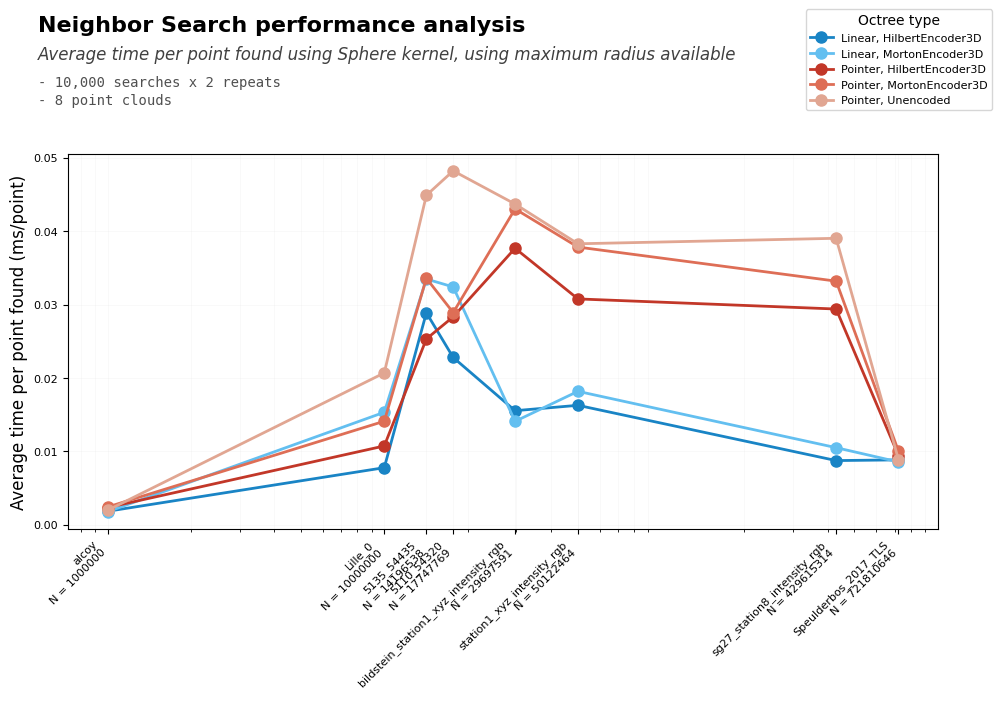

In [23]:
fig = tpp_max_avg_result_size(
    CLOUDS_DATASETS_TPP,
    kernel="Sphere",
    operation='neighSearch',
    operation_name='Neighbor Search'
)

In [24]:
# Getting the biggest avg_result_size instead of fixing kernel,radius so datasets with different densities 
# all have a lot of points found

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def tpp_closest_to_target_avg(clouds_datasets, kernel, target_avg, operation, operation_name, types_info=TYPES_INFO_OCTREE_ENCODER, data_path=TPP_DATA_PATH):
    dfs = read_multiple_datasets(clouds_datasets, data_path)
    fig, ax = plt.subplots(figsize=(12, 6))
    implementation_data = {}
    legend_handles, legend_labels = [], []
    x_labels, x_ticks = [], []

    for df_name, df in dfs.items():
        # Filter the dataframe by kernel and operation
        df = df[(df['kernel'] == kernel) & (df['operation'] == operation)]
        # Need to reset the index so we can use idxmax
        df = df.reset_index(drop=True) 

        # Find the row with avg_result_size closest to the target_avg_max
        closest_row = df.iloc[(df['avg_result_size'] - target_avg).abs().idxmin()]
        # Dataset size could have been taken from any row, but we take it from the closest row for convenience
        avg_size_found, chosen_radius, dataset_size = closest_row['avg_result_size'], closest_row['radius'], closest_row["npoints"]
        print(f"Dataset: {df_name}, radius chosen: {chosen_radius}, found avg_result_size: {avg_size_found}, with diff. to target: {abs(avg_size_found - target_avg)}")


        x_labels.append(f"{df_name}\nN = {dataset_size}")
        x_ticks.append(dataset_size)

        for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
            key = tuple(params[col] for col in types_info["type_parameters"])
            # Filter the dataframe by octree type
            octree_impl_df = df[
                (df[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
            ]
            if octree_impl_df.empty:
                print("Warning, no data for ", key, " with kernel = ", kernel, 
                      ", radius = ", chosen_radius, " and operation = ", operation, " at dataset ", df_name)
                
            norm_time = octree_impl_df['mean'].iloc[0] / avg_size_found  # ms / point
            if key not in implementation_data:
                implementation_data[key] = {'sizes': [], 'times': []}
            implementation_data[key]['sizes'].append(dataset_size)
            implementation_data[key]['times'].append(norm_time)

    # Plot a line for each implementation
    for key, data in implementation_data.items():
        # Sort by size to ensure proper line connection
        sizes = np.array(data['sizes'])
        times = np.array(data['times'])
        sort_idx = np.argsort(sizes)
        
        formatted_label = ", ".join(f"{value}" for value in key)
        line = ax.plot(sizes[sort_idx], times[sort_idx], 'o-', 
                      label=formatted_label, 
                      color=types_info["palette"][key],
                      linewidth=2, markersize=8)[0]
        
        if formatted_label not in legend_labels:
            legend_handles.append(line)
            legend_labels.append(formatted_label)
    
    ax.set_xscale('log')
    
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels, rotation=45, ha='right')

    ax.set_ylabel('Average time per point found (ms/point)', fontsize=12)
    
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)
    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Analysis of average time to find points over multiple datasets using {kernel} kernel\n"
        f"Radius taken is the one making avg. result size closest to {target_avg}",
        fig,
        h_title = 0.98,
        h_subtitle  = 0.93
    )

    # This values should be the same for all datasets, otherwise data is inconsistent
    nsearches = closest_row['num_searches']
    nrepeats = closest_row['repeats']
    add_execution_details_multiple_datasets(dfs.keys(), nsearches, nrepeats, fig, h_ex = 0.86)
    
    plt.subplots_adjust(right=0.85, top=0.75)

    return fig

Loading latest file: out/tpp_comp/alcoy/alcoy-2025-01-24-11:15:13.csv
Loading latest file: out/tpp_comp/Lille_0/Lille_0-2025-01-27-13:25:14.csv
Loading latest file: out/tpp_comp/5110_54320/5110_54320-2025-01-27-16:31:50.csv
Loading latest file: out/tpp_comp/5135_54435/5135_54435-2025-01-27-16:28:15.csv
Loading latest file: out/tpp_comp/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-01-27-14:28:36.csv
Loading latest file: out/tpp_comp/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-01-27-14:44:08.csv
Loading latest file: out/tpp_comp/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-2025-01-27-14:34:58.csv
Loading latest file: out/tpp_comp/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-27-13:33:17.csv
Dataset: alcoy, radius chosen: 15, found avg_result_size: 6697, with diff. to target: 23303
Dataset: Lille_0, radius chosen: 1.0, found avg_result_size: 8223, with diff. to target: 21777
Dataset: 5110_54320, radius chosen: 12, found avg_r

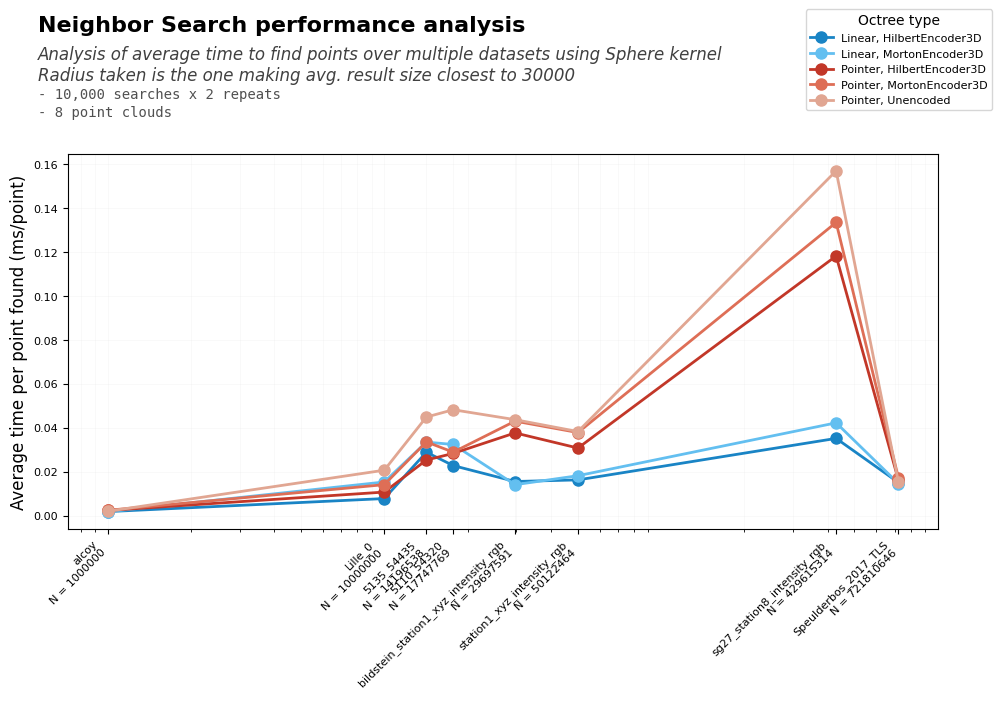

In [25]:
fig = tpp_closest_to_target_avg(
    CLOUDS_DATASETS_TPP,
    kernel="Sphere",
    target_avg=30000,
    operation='neighSearch',
    operation_name='Neighbor Search'
)

In [26]:
CLOUDS_DATASETS = {"Lille_0": "Paris_Lille", 
                    "Lille_11": "Paris_Lille",
                    "Paris_Luxembourg_6": "Paris_Lille",
                    "5110_54320": "Dales_LAS",
                    "5135_54435": "Dales_LAS",
                    "bildstein_station1_xyz_intensity_rgb": "Semantic3D",
                    "sg27_station8_intensity_rgb": "Semantic3D",
                    "station1_xyz_intensity_rgb": "Semantic3D",
                    "Speulderbos_2017_TLS": "Speulderbos"
                }

In [27]:
# Idea 3.
def multiple_dfs_runtimes(clouds_datasets, kernel, radii, operation, operation_name, types_info=TYPES_INFO_OCTREE_ENCODER):
    dfs = read_multiple_datasets(clouds_datasets)
    fig, axes = plt.subplots(len(radii), len(dfs), 
                              figsize=(len(dfs) * 2.5, len(radii) * 2.5),
                              gridspec_kw={'wspace': 0.7, 'hspace': 0.2})

    # Ensure axes are iterable for single-row or single-column cases
    if len(radii) == 1:
        axes = [axes]
    if len(dfs) == 1:
        axes = [[ax] for ax in axes]

    # Define bar width and spacing
    bar_width = 0.02

    legend_handles, legend_labels = [], []

    # Iterate over radii and datasets
    for radius_idx, radius in enumerate(radii):
        for df_idx, (df_name, df) in enumerate(dfs.items()):
            ax = axes[radius_idx][df_idx]

            # Filter data for the current kernel, radius, and operation
            radius_data = df[(df['kernel'] == kernel) & (df['radius'] == radius) & (df['operation'] == operation)]

            if radius_data.empty:
                ax.text(0.5, 0.5, f"No data available\n{df_name}\nRadius = {radius}",
                        transform=ax.transAxes, ha='center', va='center', fontsize=8, color='red')
                ax.axis('off')
                continue
            
            # Iterate through octree implementations
            for j, (_, params) in enumerate(types_info["available_types"].iterrows()):
                key = tuple(params[col] for col in types_info["type_parameters"])
                octree_data = radius_data[
                    (radius_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]

                if octree_data.empty:
                    continue

                means = octree_data['mean'].values
                stdevs = octree_data['stdev'].values
                x_pos = j * bar_width
                bar = ax.bar(x_pos, means[0], bar_width, color=types_info["palette"][key])
                ax.errorbar(x_pos, means[0], stdevs[0],
                            color='gray', capsize=2, capthick=1,
                            fmt='none', elinewidth=1)

                formatted_label = ", ".join(f"{value}" for param, value in zip(types_info["type_parameters"], key))
                if (radius_idx == 0) and (df_idx == 0) and (formatted_label not in legend_labels):
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)
                ax.text(0.04, 0.96, f'r = {radius}', 
                    transform=ax.transAxes,
                    fontsize=9, va='top', ha='left')
            # Remove x-ticks
            ax.set_xticks([])
            ax.set_ylabel('Executime time (ms)', fontsize=10)

            avg_total = radius_data['avg_result_size'].iloc[0]
            ax.text(0.5, -0.1, f"Avg. points = {avg_total:,.0f}", 
                    transform=ax.transAxes, ha='center', va='center', fontsize=8)
            
    # Adjust subplot spacing
    plt.subplots_adjust(hspace=0.4, wspace=0.3)
    # Add legend and titles
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)

    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Comparison of runtime performance across datasets and octree implementations for {operation_name} using {kernel} kernel\n",
        fig
    )

    # Assuming the first dataframe has consistent metadata
    nsearches = dfs[next(iter(dfs))]['num_searches'].iloc[0]
    nrepeats = dfs[next(iter(dfs))]['repeats'].iloc[0]
    add_execution_details_multiple_datasets(dfs.keys(), nsearches, nrepeats, fig, h_ex=0.93)

    return fig

Loading latest file: out/Lille_0/Lille_0-2025-02-28-17:10:08.csv
Loading latest file: out/Lille_11/Lille_11-2025-01-23-12:24:54.csv
Loading latest file: out/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-23-11:57:36.csv
Loading latest file: out/5110_54320/5110_54320-2025-01-24-02:35:08.csv
Loading latest file: out/5135_54435/5135_54435-2025-01-24-02:31:50.csv
Loading latest file: out/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-01-23-12:40:46.csv
Loading latest file: out/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-01-23-14:02:31.csv
Loading latest file: out/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-2025-01-23-13:24:46.csv
Loading latest file: out/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-21-21:31:17.csv


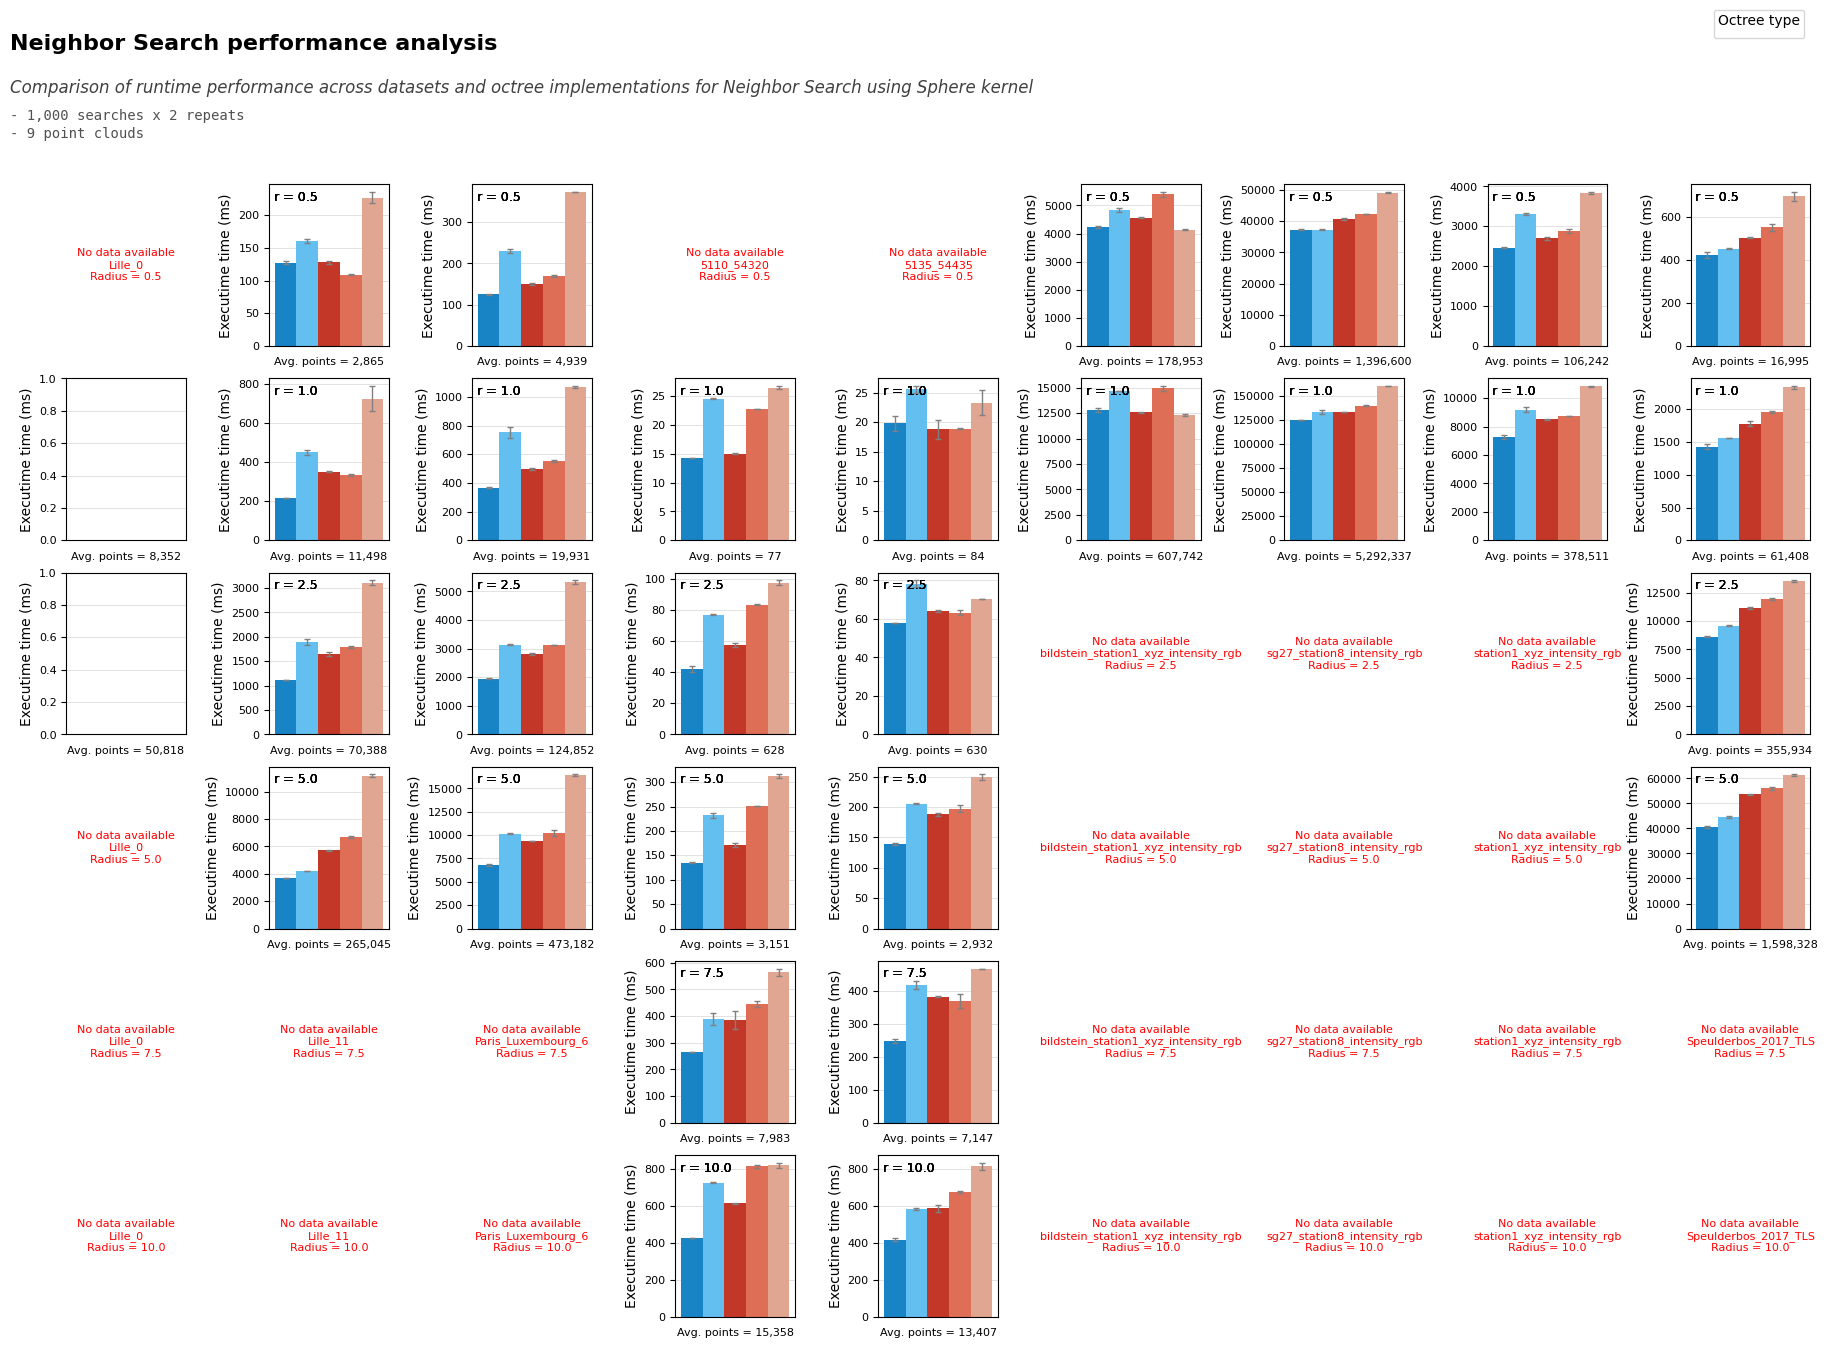

In [28]:
fig = multiple_dfs_runtimes(
    CLOUDS_DATASETS, 
    kernel="Sphere", 
    radii=[0.5, 1.0, 2.5, 5.0, 7.5, 10.0], 
    operation='neighSearch', 
    operation_name='Neighbor Search'
)

In [29]:
def multiple_dfs_improvements(clouds_datasets, kernel, radii, operation, operation_name, types_info=TYPES_INFO_OCTREE_ENCODER):
    dfs = read_multiple_datasets(clouds_datasets)
    fig, axes = plt.subplots(len(radii), len(dfs), 
                              figsize=(len(dfs) * 2.5, len(radii) * 2.5),
                              gridspec_kw={'wspace': 0.7, 'hspace': 0.2})

    # Ensure axes are iterable for single-row or single-column cases
    if len(radii) == 1:
        axes = [axes]
    if len(dfs) == 1:
        axes = [[ax] for ax in axes]

    # Define bar width and spacing
    bar_width = 0.02

    legend_handles, legend_labels = [], []

    # Iterate over radii and datasets
    for radius_idx, radius in enumerate(radii):
        for df_idx, (df_name, df) in enumerate(dfs.items()):
            ax = axes[radius_idx][df_idx]

            # Filter data for the current kernel, radius, and operation
            radius_data = df[(df['kernel'] == kernel) & (df['radius'] == radius) & (df['operation'] == operation)]

            if radius_data.empty:
                ax.text(0.5, 0.5, f"No data\n{df_name}\nRadius = {radius}",
                        transform=ax.transAxes, ha='center', va='center', fontsize=8, color='red')
                ax.axis('off')
                continue

            # Kernel label
            avg_total = radius_data['avg_result_size'].iloc[0]
            
            # Add radius label in top-left of each subplot
            ax.text(0.05, 0.95, f'r = {radius}', 
                    transform=ax.transAxes,
                    fontsize=9, va='top', ha='left')

            # Find base execution time for "Pointer" octree and "Unencoded" encoder
            base_data = radius_data[(radius_data['octree'] == "Pointer") & (radius_data['encoder'] == "Unencoded")]
            base_time = base_data['mean'].iloc[0]  # Base execution time for the reference combination

            # Iterate through octree implementations
            # Reverse the list to show increasing improvements
            rev_list = list(types_info["available_types"].iterrows())[::-1]
            for j, (_, params) in enumerate(rev_list):
                key = tuple(params[col] for col in types_info["type_parameters"])
                # Skip the baseline (Pointer, Unencoded) combination
                if key == ("Pointer", "Unencoded"):
                    continue
                octree_data = radius_data[
                    (radius_data[types_info["type_parameters"]] == pd.Series(key, index=types_info["type_parameters"])).all(axis=1)
                ]

                if octree_data.empty:
                    continue

                means = octree_data['mean'].values
                # Calculate the efficiency increase in percentage
                improvement = ((base_time - means[0]) / base_time) * 100

                x_pos = j * bar_width
                bar = ax.bar(x_pos, improvement, bar_width, color=types_info["palette"][key])

                formatted_label = ", ".join(f"{value}" for param, value in zip(types_info["type_parameters"], key))
                if (radius_idx == 0) and (df_idx == 0) and (formatted_label not in legend_labels):
                    legend_handles.append(bar)
                    legend_labels.append(formatted_label)

            # Remove x-ticks
            ax.set_xticks([])
            ax.set_ylabel('Improvement (%)', fontsize=9)

            ax.text(0.5, -0.1, f"Avg. points = {avg_total:,.0f}", 
                    transform=ax.transAxes, ha='center', va='center', fontsize=8)

    # Adjust subplot spacing
    plt.subplots_adjust(hspace=0.4, wspace=0.3, bottom=0.15)
    
    # Add legend and titles
    add_octree_types_legend(legend_handles, legend_labels, "Octree type", fig)

    add_title_subtitle(
        f"{operation_name} performance analysis",
        f"Increase in runtime efficiency with respect to baseline Pointer-based octree using {kernel} kernel",
        fig
    )

    # Assuming the first dataframe has consistent metadata
    nsearches = dfs[next(iter(dfs))]['num_searches'].iloc[0]
    nrepeats = dfs[next(iter(dfs))]['repeats'].iloc[0]
    add_execution_details_multiple_datasets(df.keys(), nsearches, nrepeats, fig, 0.93)

    return fig

Loading latest file: out/Lille_0/Lille_0-2025-02-28-17:10:08.csv
Loading latest file: out/Lille_11/Lille_11-2025-01-23-12:24:54.csv
Loading latest file: out/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-23-11:57:36.csv
Loading latest file: out/5110_54320/5110_54320-2025-01-24-02:35:08.csv
Loading latest file: out/5135_54435/5135_54435-2025-01-24-02:31:50.csv
Loading latest file: out/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-01-23-12:40:46.csv
Loading latest file: out/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-01-23-14:02:31.csv
Loading latest file: out/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-2025-01-23-13:24:46.csv
Loading latest file: out/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-21-21:31:17.csv


IndexError: single positional indexer is out-of-bounds

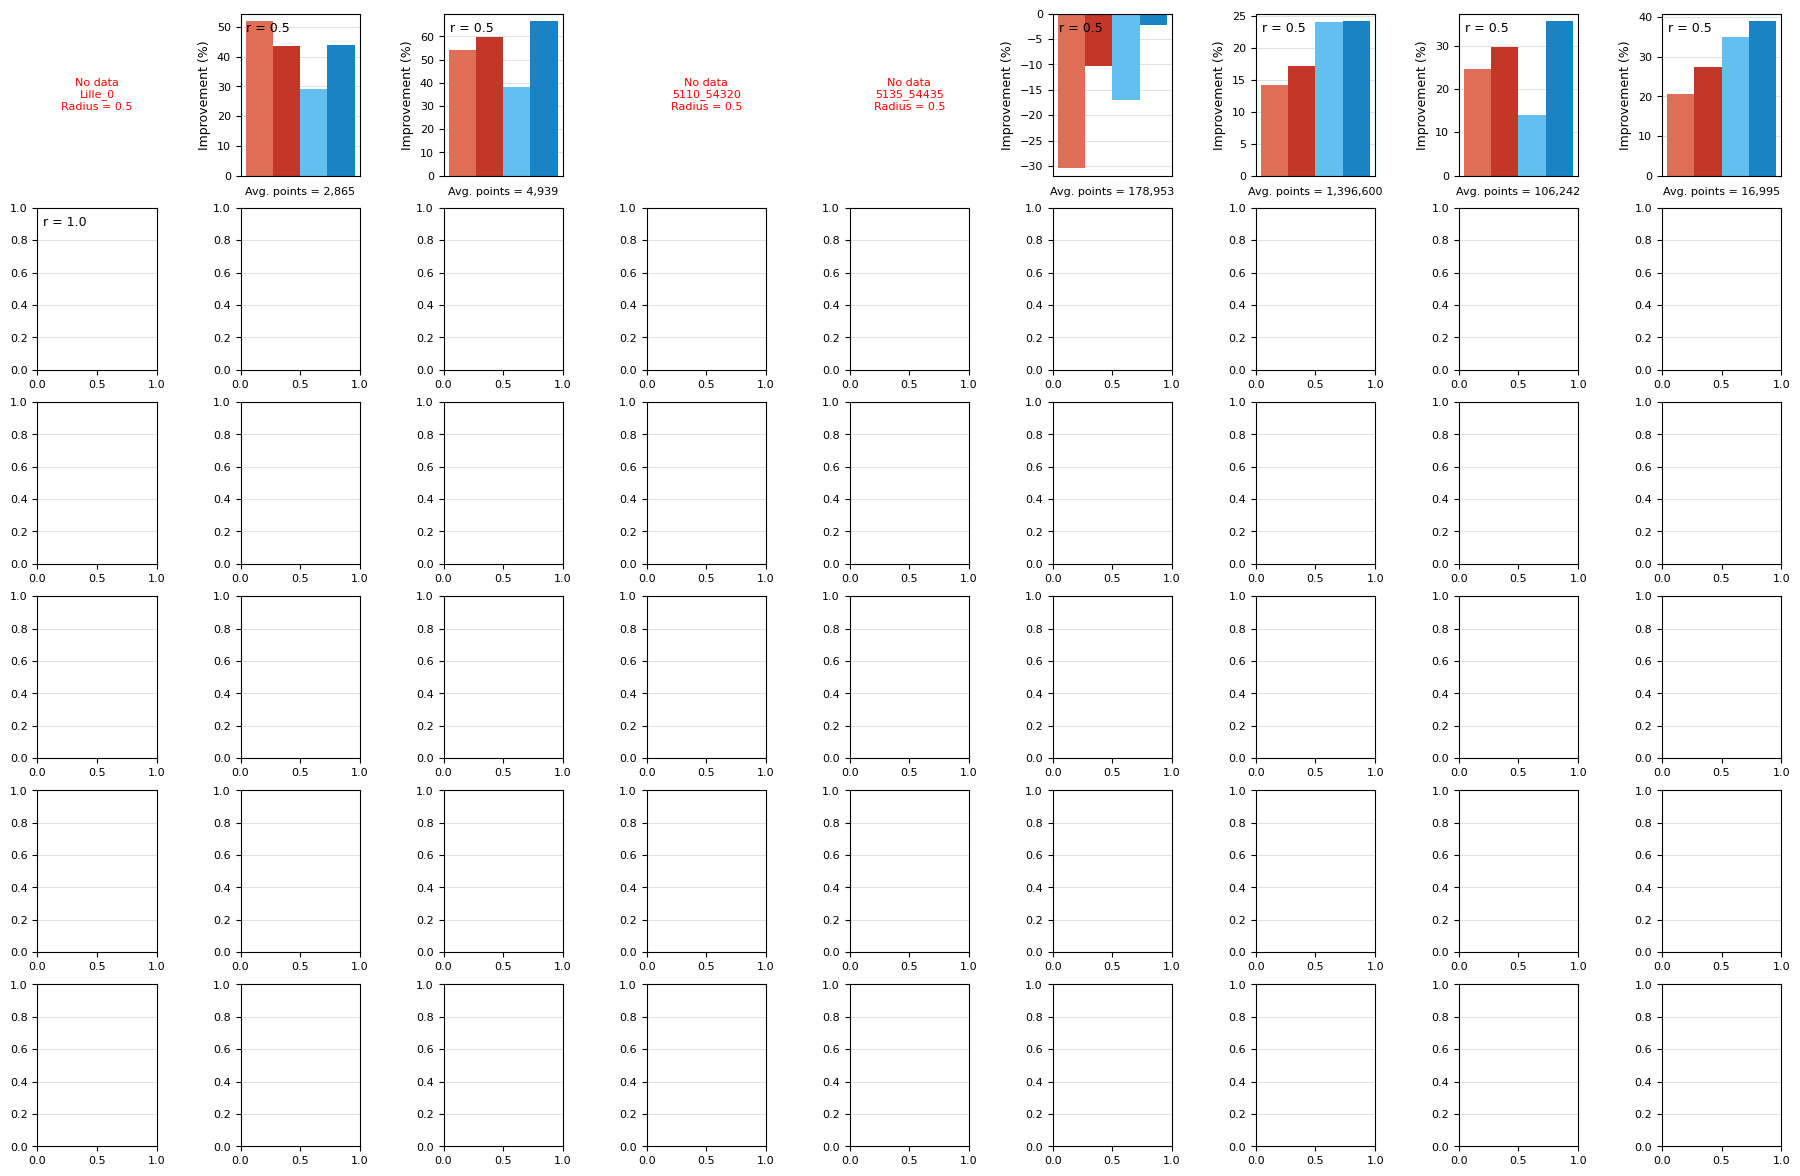

In [30]:
fig = multiple_dfs_improvements(
    CLOUDS_DATASETS, 
    kernel="Sphere", 
    radii=[0.5, 1.0, 2.5, 5.0, 7.5, 10.0], 
    operation='neighSearch', 
    operation_name='Neighbor Search'
)

In [ ]:
# Save a lot of plots
for cloud, dataset in CLOUDS_DATASETS.items():
    output_fig(octree_runtime_comparison(cloud, dataset, 'neighSearch', 'Neighbors search'), "neigh_search", dataset, cloud)
    output_fig(octree_runtime_comparison(cloud, dataset, 'neighSearch', 'Num. of neighbors search'), "num_neigh_search", dataset, cloud)
    output_fig(octree_runtime_comparison(cloud, dataset, 'neighSearch', 'Neighbors search', True), "neigh_search_warmup", dataset, cloud)
    output_fig(octree_runtime_comparison(cloud, dataset, 'neighSearch', 'Num. of Neighbors search', True), "num_neigh_search_warmup", dataset, cloud)

Loading latest file: out/Lille_0/Lille_0-2025-01-23-11:45:48.csv
Loading latest file: out/Lille_0/Lille_0-2025-01-23-11:45:48.csv
Loading latest file: out/Lille_0/Lille_0-2025-01-23-11:45:48.csv
Loading latest file: out/Lille_0/Lille_0-2025-01-23-11:45:48.csv
Loading latest file: out/Lille_11/Lille_11-2025-01-23-12:24:54.csv
Loading latest file: out/Lille_11/Lille_11-2025-01-23-12:24:54.csv
Loading latest file: out/Lille_11/Lille_11-2025-01-23-12:24:54.csv
Loading latest file: out/Lille_11/Lille_11-2025-01-23-12:24:54.csv
Loading latest file: out/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-23-11:57:36.csv
Loading latest file: out/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-23-11:57:36.csv
Loading latest file: out/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-23-11:57:36.csv
Loading latest file: out/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-23-11:57:36.csv
Loading latest file: out/5110_54320/5110_54320-2025-01-24-02:35:08.csv
Loading latest file: out/5110_54320/5110_54320-2025-0

In [ ]:
CLOUDS_DATASETS_ALGO_COMPS = {"Lille_0": "Paris_Lille", 
                        "Paris_Luxembourg_6": "Paris_Lille",
                        "5135_54435": "Dales_LAS"
                    }
ALGO_COMP_DATA_PATH = os.path.join(BASE_DATA_PATH, "algo_comp")
for cloud, dataset in CLOUDS_DATASETS_ALGO_COMPS.items():
    output_fig(octree_operations_comparison(cloud, dataset, ['neighSearch', 'neighOldSearch'], data_path=ALGO_COMP_DATA_PATH), "compare_impl_neigh_search", dataset, cloud)
    output_fig(octree_operations_comparison(cloud, dataset, ['numNeighSearch', 'numNeighOldSearch'], data_path=ALGO_COMP_DATA_PATH), "compare_impl_num_neigh_search", dataset, cloud)

Loading latest file: out/algo_comp/Lille_0/Lille_0-2025-01-24-02:39:09.csv
Loading latest file: out/algo_comp/Lille_0/Lille_0-2025-01-24-02:39:09.csv
Loading latest file: out/algo_comp/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-24-02:47:02.csv
Loading latest file: out/algo_comp/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-24-02:47:02.csv
Loading latest file: out/algo_comp/5135_54435/5135_54435-2025-01-24-03:03:08.csv
Loading latest file: out/algo_comp/5135_54435/5135_54435-2025-01-24-03:03:08.csv


In [ ]:
output_fig(tpp_max_avg_result_size(CLOUDS_DATASETS_TPP, kernel="Sphere", operation='neighSearch', operation_name='Neighbors Search'), "tpp_neigh_search_max_radius")
output_fig(tpp_max_avg_result_size(CLOUDS_DATASETS_TPP, kernel="Sphere", operation='numNeighSearch', operation_name='Num. of Neighbors Search'), "tpp_num_neigh_search_max_radius")
TARGET_AVG = 30000
output_fig(tpp_closest_to_target_avg(CLOUDS_DATASETS_TPP, kernel="Sphere", target_avg=TARGET_AVG, operation='neighSearch', operation_name='Neighbors Search'), f"tpp_num_neigh_search_avg_near_{TARGET_AVG}")
output_fig(tpp_closest_to_target_avg(CLOUDS_DATASETS_TPP, kernel="Sphere", target_avg=TARGET_AVG, operation='numNeighSearch', operation_name='Num. of Neighbors Search'),f"tpp_num_neigh_search_avg_near_{TARGET_AVG}")

Loading latest file: out/tpp_comp/alcoy/alcoy-2025-01-24-11:15:13.csv
Loading latest file: out/tpp_comp/Lille_0/Lille_0-2025-01-27-13:25:14.csv
Loading latest file: out/tpp_comp/5110_54320/5110_54320-2025-01-27-16:31:50.csv
Loading latest file: out/tpp_comp/5135_54435/5135_54435-2025-01-27-16:28:15.csv
Loading latest file: out/tpp_comp/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-01-27-14:28:36.csv
Loading latest file: out/tpp_comp/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-01-27-14:44:08.csv
Loading latest file: out/tpp_comp/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-2025-01-27-14:34:58.csv
Loading latest file: out/tpp_comp/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-27-13:33:17.csv
Dataset: alcoy, radius taken: 15, max avg_result_size: 6697
Dataset: Lille_0, radius taken: 1.0, max avg_result_size: 8223
Dataset: 5110_54320, radius taken: 12, max avg_result_size: 23249
Dataset: 5135_54435, radius taken: 12, max avg_re

In [ ]:
RADII = [0.5, 1.0, 2.5, 5.0, 7.5, 10.0]
output_fig(multiple_dfs_runtimes(CLOUDS_DATASETS, kernel="Sphere", radii=RADII, operation='neighSearch', operation_name='Neighbors Search'), "multiple_datasets_neigh_search")
output_fig(multiple_dfs_runtimes(CLOUDS_DATASETS, kernel="Sphere", radii=RADII, operation='numNeighSearch', operation_name='Num. of Neighbors Search'), "multiple_datasets_num_neigh_search")
output_fig(multiple_dfs_improvements(CLOUDS_DATASETS, kernel="Sphere", radii=RADII, operation='neighSearch', operation_name='Neighbors Search'), "multiple_datasets_neigh_search_improvements")
output_fig(multiple_dfs_improvements(CLOUDS_DATASETS, kernel="Sphere", radii=RADII, operation='numNeighSearch', operation_name='Num. of Neighbors Search'), "multiple_datasets_num_neigh_search_improvements")

Loading latest file: out/Lille_0/Lille_0-2025-01-23-11:45:48.csv
Loading latest file: out/Lille_11/Lille_11-2025-01-23-12:24:54.csv
Loading latest file: out/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-23-11:57:36.csv
Loading latest file: out/5110_54320/5110_54320-2025-01-24-02:35:08.csv
Loading latest file: out/5135_54435/5135_54435-2025-01-24-02:31:50.csv
Loading latest file: out/bildstein_station1_xyz_intensity_rgb/bildstein_station1_xyz_intensity_rgb-2025-01-23-12:40:46.csv
Loading latest file: out/sg27_station8_intensity_rgb/sg27_station8_intensity_rgb-2025-01-23-14:02:31.csv
Loading latest file: out/station1_xyz_intensity_rgb/station1_xyz_intensity_rgb-2025-01-23-13:24:46.csv
Loading latest file: out/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-21-21:31:17.csv
Loading latest file: out/Lille_0/Lille_0-2025-01-23-11:45:48.csv
Loading latest file: out/Lille_11/Lille_11-2025-01-23-12:24:54.csv
Loading latest file: out/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-23-11:57:36.cs

In [ ]:
CLOUDS_DATASETS_POINT_COMPS = { "Lille_0": "Paris_Lille", 
                                "Paris_Luxembourg_6": "Paris_Lille",
                                "Lille_11": "Paris_Lille",
                                "Speulderbos_2017_TLS": "Speulderbos"
                            }
for cloud, dataset in CLOUDS_DATASETS_POINT_COMPS.items():
    output_fig(octree_runtime_comparison(cloud, dataset, 'neighSearch', 'Neighbors search', True, TYPES_INFO_OCTREE_POINT, os.path.join(BASE_DATA_PATH, "point_comp")), "point_comp_neigh_search", dataset, cloud)
    output_fig(octree_runtime_comparison(cloud, dataset, 'numNeighSearch', 'Num. of neighbors search', True, TYPES_INFO_OCTREE_POINT, os.path.join(BASE_DATA_PATH, "point_comp")), "point_comp_num_neigh_search", dataset, cloud)

Loading latest file: out/point_comp/Lille_0/Lille_0-2025-01-28-13:06:05.csv
Loading latest file: out/point_comp/Lille_0/Lille_0-2025-01-28-13:06:05.csv
Loading latest file: out/point_comp/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-28-13:18:16.csv
Loading latest file: out/point_comp/Paris_Luxembourg_6/Paris_Luxembourg_6-2025-01-28-13:18:16.csv
Loading latest file: out/point_comp/Lille_11/Lille_11-2025-01-28-13:45:06.csv
Loading latest file: out/point_comp/Lille_11/Lille_11-2025-01-28-13:45:06.csv
Loading latest file: out/point_comp/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-28-14:02:58.csv
Loading latest file: out/point_comp/Speulderbos_2017_TLS/Speulderbos_2017_TLS-2025-01-28-14:02:58.csv
